# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# changing the time columns type
from datetime import datetime
# Plotting NaN values
# import missingno as msno

import os

# for uncertainties
from uncertainties import ufloat
import uncertainties as uc
import statsmodels.api as sm
from scipy import stats

# plt.rcParams["text.usetex"] = True

# Funkctions

In [3]:
class sbk():
  def chaning_type_time(df,col_name='Time'):
    """
    only to change from 16-16-16 to 16:16:16
    """
    df[col_name] = df[col_name].str.replace('-',':')
    df[col_name] = pd.to_datetime(df[col_name],format='%H:%M:%S').dt.time
    return df[col_name]

  def getting_R_data(link):
    r_dict = {
        'Current':'I [microA]',
        'Voltage':'U [microV]',
        'Power':'P [W]',
        'Resistence':'R [O]',
        'SourceDelay':'SD [s]',
        'VoltageLimit':'VL [V]'
    }
    df = pd.read_csv(link,skiprows=range(0, 27),sep=' ', encoding='latin1')
    df = df.rename(columns=r_dict)
    df = df.drop([0])
    for i in df.columns:
      if i == 'I [microA]':
        df[i] = pd.to_numeric(df[i])*1e6
      elif i == 'U [microV]':
        df[i] = pd.to_numeric(df[i])*1e6
      else:
        df[i] = pd.to_numeric(df[i])
    return df

  def find_files_with_us(directory):
    files_with_us = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if 'Us' in file:
                files_with_us.append(os.path.join(root, file))
    return files_with_us

  def var(array,mean):
    length = len(array)
    y = sum((array-mean)**2)/(length-1)
    return y

  def reg(x,a,b):
    return a*x+b

  def sxsq(x):
    mean = np.mean(x)
    t = sum((x-mean)**2)/len(x)
    return t

  def sxy(x,y):
    xx = x-np.mean(x)
    yy = y-np.mean(y)
    return sum(xx*yy)/len(x)

  def lst_of_rs(link,var1='295',var2='1,8,16,9'):
    lst = []
    lst_link = []
    if (var1 and var2) in link:
      x = sbk.getting_R_data(link)
      lst.append(x)
      lst_link.append(link)
    return lst, lst_link

  def S_rel(Us,T):
    return -Us/T
  # TdM, S. 853f
  def rxy(x,y):
    z = sum((x-np.mean(x))*(y-np.mean(y)))/np.sqrt(sum((x-np.mean(x))**2)*sum(y-np.mean(y)))
    return z

  def t(x,y):
    z = sbk.rxy(x,y)*np.sqrt(len(x)-2)/np.sqrt(1-sbk.rxy(x,y)**2)
    return z

  def b_tilde(x,y):
    z=  sum((x-np.mean(x))*(y-np.mean(y)))/sum((x-np.mean(x))**2)
    return z
  def sy(y):
    z = 1/(len(y)-1) * sum(y-np.mean(y)**2)
    return z
  def sigma_sq(x,y):
    z = (len(x)-1)/(len(x)-2)* sbk.sy(y) *(1-sbk.rxy(x,y))
    return z

  def std_sig(x,y):
    z = np.sqrt(sbk.sigma_sq(x,y))
    return z

  def a_tilde(x,y):
    z = np.mean(y) - sbk.b_tilde(x,y) * np.mean(x)
    return z

  def lin_reg(x,y):
    if len(x)>2:
      sigma = sbk.sigma_sq(x,y)
      std = np.sqrt(sigma)
    else:
      sigma = 'Not Possible, because the length of x<=2'
      std = 'Not Possible'
    a = sbk.a_tilde(x,y)
    b = sbk.b_tilde(x,y)
    return a,b,sigma, std

# Data Loading

In [4]:
Link = 'https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/Seebeck-Effect/Data/SK-Data.xlsx'
data = pd.ExcelFile(Link)
sheets = data.sheet_names
for i in range(4):
  print(sheets[i])

Data-for-Ri-sheets
Voltage-Data
Zusammenfassung
Data Reader 1


In [5]:
direct = 'Data/'
files = os.listdir(direct)
data_lst = [file for file in files if file.endswith('.txt')]
d_lst = [file for file in data_lst if 'test' not in file]
d_lst = sorted(d_lst)

# Data in Data Frames

In [6]:
# data sheet with information about the ri's
df_data_for_ris = pd.read_excel(data,sheet_name=sheets[0])
# changing index of the data frame df_data_for_ris
df_data_for_ris = df_data_for_ris.rename(columns={'Unnamed: 0':'index'})
df_data_for_ris.index = df_data_for_ris['index']
df_data_for_ris = df_data_for_ris.drop(['index'],axis=1)
# changing the type of the column Time
df_data_for_ris['Time'] = sbk.chaning_type_time(df_data_for_ris)

# the voltage sheet
df_us = pd.read_excel(data,sheet_name=sheets[1])
# deleting a not necessary column
df_us = df_us.drop(['Unnamed: 0'],axis=1)
# changing type of the Time column
df_us['Time'] = sbk.chaning_type_time(df_us)

# the zusammenfassung sheet
df_zf = pd.read_excel(data,sheet_name=sheets[2])
# new index for df_zf
index = []
for i in range(len(df_zf)):
  index.append('R')
df_zf.index = index
df_zf = df_zf.drop(['Unnamed: 0'],axis=1)
#changing the type of Time column
df_zf['Time'] = sbk.chaning_type_time(df_zf)

# the datareader 1 sheet
df_data_reader_1 = pd.read_excel(data,sheet_name=sheets[3])
df_data_reader_1 = df_data_reader_1.drop(['Unnamed: 0'],axis=1)
# print(msno.matrix(df_data_reader_1))
df_data_reader_1= df_data_reader_1.drop(['R'],axis=1)
df_data_reader_1 = df_data_reader_1.rename(columns={'DateTime':'Time',
                                                    't':'t [s]','dt':'dt [s]',
                                                    'Temp1':'T1 [K]',
                                                    'Temp2':'T2 [K]',
                                                    'dT1/dt': 'dT1/dt [K/min]',
                                                    'dT2/dt': 'dT2/dt [K/min]'
                                                    })
df_data_reader_1 = df_data_reader_1.drop(0)
# changing datetime
time = []
for i in df_data_reader_1['Time']:
  x = i.split(sep='_')
  time.append(x[1])
# print(time)
df_data_reader_1['Time'] = time
df_data_reader_1['Time'] = sbk.chaning_type_time(df_data_reader_1)
lst = ['t [s]','dt [s]','dt [s]','T1 [K]','T2 [K]','SetPoint','dT1/dt [K/min]','dT1/dt [K/min]']
for i in lst:
  df_data_reader_1[i] = pd.to_numeric(df_data_reader_1[i])

# showing the heads
print(type(df_data_reader_1['dT2/dt [K/min]'][2]))
df_data_reader_1.head()

<class 'float'>


,Time,t [s],dt [s],T1 [K],T2 [K],SetPoint,dT1/dt [K/min],dT2/dt [K/min]
1,15:53:19,3.549777e+09,13.242,295.74,296.16,295.0,NaN,NaN
2,15:53:19,3.549777e+09,13.638,295.73,296.15,295.0,NaN,NaN
3,15:53:20,3.549778e+09,14.638,295.73,296.15,295.0,NaN,NaN
4,15:53:21,3.549779e+09,15.638,295.73,296.15,295.0,NaN,NaN
5,15:53:22,3.549780e+09,16.638,295.72,296.14,295.0,NaN,NaN


In [7]:
n = list(np.arange(4,26))
r = []
for i in n:
  df = pd.read_excel(data,sheet_name=sheets[i])
  df = df.rename(columns={'Unnamed: 0':'index'})
  df.index = df['index']
  df = df.drop(['index'],axis=1)
  r.append(df)

In [8]:
r[15].head()

,Current [A],Volt [V],Power [W],Ressistent [R],Source Delay [s],Volt. Lim. [V]
index,,,,,,
1,0.000000e+00,0.000002,0.000000e+00,0.00000,5.00,1
2,0.000000e+00,0.000002,0.000000e+00,0.00000,1.00,1
3,1.000000e-07,0.000003,2.512968e-13,25.12968,0.01,1
4,2.000000e-07,0.000003,6.487174e-13,16.21794,0.01,1
5,3.000000e-07,0.000004,1.200716e-12,13.34129,0.01,1


# Time Serie plots

## Data Reader

In [9]:
df_data_reader_1.head()
df_dr1 = df_data_reader_1.copy()
df_dr1 = df_dr1.dropna()

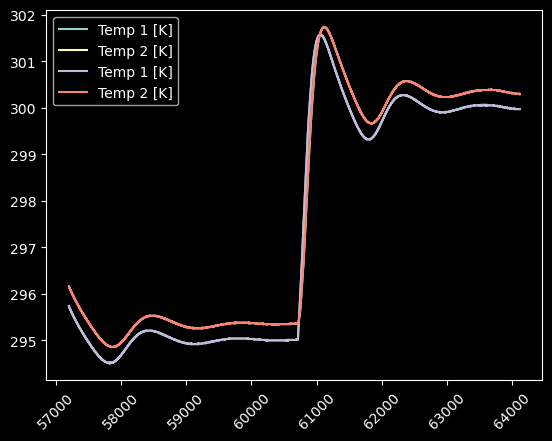

In [ ]:
x = df_data_reader_1['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
x1 = df_dr1['Time'].apply(lambda x: datetime(2023, 1, 1, x.hour, x.minute, x.second))
# print(df_data_reader_1.columns)
y1 = df_data_reader_1['t [s]']
y2 = df_data_reader_1['T1 [K]']
y3 = df_data_reader_1['T2 [K]']
y4 = df_data_reader_1['dT1/dt [K/min]']
y41 = df_dr1['dT1/dt [K/min]']
y5 = df_data_reader_1['dT2/dt [K/min]']
y51 = df_dr1['dT2/dt [K/min]']

# plt.plot(x,y1,label='t [s]')
plt.plot(x,y2, label='Temp 1 [K]')
plt.plot(x,y3, label='Temp 2 [K]')
# plt.plot(x1,y41,label='dT1/dt [K/min]')
# plt.plot(x1,y51,label='dT2/dt [K/min]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Zusammenfassung:

In [12]:
df_zf.head()

,I+,I-,V+,V-,Widerstand[Ohm],Time,T1 [K],Sample T [K],I [mA],wanted T [K],File number
R,1,8,16,9,10.117290,16:28:14,294.94,295.27,0,295,1
R,15,10,14,11,7.315538,16:28:14,294.94,295.27,0,295,1
R,1,8,16,9,10.123770,16:37:59,295.04,295.38,3,295,1
R,15,10,14,11,7.323552,16:37:59,295.04,295.38,3,295,1
R,1,8,16,9,10.137490,16:41:32,295.02,295.36,6,295,1


In [13]:
# plt.plot(df_zf['Time'],df_zf['T1 [K]'])

# Aufgabe 1

U heiß: 9, 16

U kalt: 14,11

## Teilaufgabe 1

Spannung in Abhängigkeit des Stroms für die Bestimmung des Widerstands
für das heiße $U_{Th}(I_{Th})$ und kalte Thermometer $U_{Tk}(I_{Tk})$ bei $I_H = 0$ bei allen
vier Temperaturen

### Loading Data

In [14]:
# d_lst

In [20]:
d_lst.index('2023-11-09_17-30-32 0001 300K_R_I0mA(1,8,16,9)T1=299.92K T2=300.23K .txt')

25

In [23]:
# 9, 16 heiß
# 14, 11 kalt
r_hI0_295 = sbk.getting_R_data('Data/' + d_lst[1])
r_kI0_295 = sbk.getting_R_data('Data/' + d_lst[2])
r_hi0_300 = sbk.getting_R_data('Data/' + d_lst[25])
r_ki0_300 = sbk.getting_R_data('Data/' + d_lst[26])

In [17]:
# r_hi0_300.head()

In [24]:
uc_r_hi0_295 = [r_hI0_295['I [microA]'] * 0.1, r_hI0_295['U [microV]'] * 0.1]
uc_r_kI0_295 = [r_kI0_295['I [microA]'] * 0.1, r_kI0_295['U [microV]'] * 0.1]
uc_r_hi0_300 = [r_hi0_300['I [microA]'] * 0.1, r_hi0_300['U [microV]'] * 0.1]
uc_r_ki0_300 = [r_ki0_300['I [microA]'] * 0.1, r_ki0_300['U [microV]'] * 0.1]

### Plot

 mit Unsicherheitsabschätzung von 10%

#### Regression

In [25]:
X = sm.add_constant(r_kI0_295['I [microA]'])
X1 = sm.add_constant(r_ki0_300['I [microA]'])
m = sm.WLS(r_kI0_295['U [microV]'],X,weights=uc_r_kI0_295[1])
m1 = sm.WLS(r_ki0_300['U [microV]'],X,weights=uc_r_ki0_300[1])
r = m.fit()
r1 = m1.fit()

In [26]:
print(r.summary())

                            WLS Regression Results                            
Dep. Variable:             U [microV]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.273e+08
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:46:27   Log-Likelihood:                 353.55
No. Observations:                 112   AIC:                            -703.1
Df Residuals:                     110   BIC:                            -697.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7586      0.002    708.210      0.0

In [27]:
print(r1.summary())

                            WLS Regression Results                            
Dep. Variable:             U [microV]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.216e+08
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:46:28   Log-Likelihood:                 351.54
No. Observations:                 112   AIC:                            -699.1
Df Residuals:                     110   BIC:                            -693.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7766      0.003    702.642      0.0

In [29]:
a295 = r.params[1]
b295 = r.params[0]
u_a295 = r.bse[1]
u_b295 = r.bse[0]
a_295_err1 = ufloat(a295,u_a295)
print(round(a295, 4), ' +/- ', round(u_a295, 4))
print(round(b295, 4), ' +/- ', round(u_b295, 4), '\n')

7.3148  +/-  0.0004
1.7586  +/-  0.0025 



C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1397715857.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a295 = r.params[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1397715857.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b295 = r.params[0]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1397715857.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_a295 = r.bse[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_

In [30]:
a300 = r1.params[1]
b300 = r1.params[0]
u_a300 = r1.bse[1]
u_b300 = r1.bse[0]
a_300_err1 = ufloat(a300,u_a300)
print(round(a300,4),' +/- ',round(u_a300,4))
print(a_300_err1)

7.3985  +/-  0.0004
7.3985+/-0.0004


C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2578986752.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a300 = r1.params[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2578986752.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b300 = r1.params[0]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2578986752.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_a300 = r1.bse[1]
C:\Users\benjf\AppData\Local\Temp\ipykern

In [31]:
# 95% confindence intervall
c295 = r.conf_int().loc['I [microA]']
round(c295,4)

0    7.3141
1    7.3155
Name: I [microA], dtype: float64

In [32]:
# 95% confindence intervall
c300 = r1.conf_int().loc['I [microA]']
round(c300,4)


0    7.3978
1    7.3993
Name: I [microA], dtype: float64

In [33]:
# help(plt.plot)

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2855570509.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$I_{Tk}$ [$\mu$A]')
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2855570509.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$U_{Tk}(I_{Tk})$ [$\mu$V]')


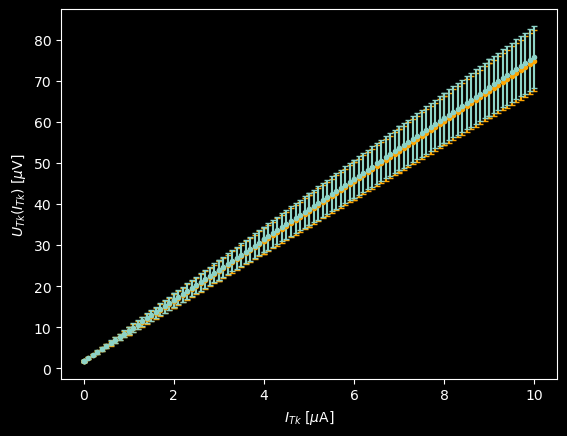

In [35]:
# Kalt:
# data
plt.errorbar(r_kI0_295['I [microA]'],r_kI0_295['U [microV]'],fmt='.',
            #  xerr=uc_r_kI0_295[0],
             yerr=uc_r_kI0_295[1],label='295K',capsize=2,color='orange',
             zorder=1)
plt.errorbar(r_ki0_300['I [microA]'],r_ki0_300['U [microV]'],fmt='.',
            #  xerr=uc_r_ki0_300[0],
             yerr=uc_r_ki0_300[1],label='300K',capsize=2,
             zorder=1)
# regressions
# plt.plot(r_kI0_295['I [microA]'],a295*r_kI0_295['I [microA]']+b295,
#          color='black',
#          label='Regression: 295K',linewidth=1,
#              zorder=2)
# plt.plot(r_ki0_300['I [microA]'],a300*r_ki0_300['I [microA]']+b300,
#          color='red',
#          zorder=2,label='Reg. 300K')
# genarell
# plt.legend()
# plt.title('kaltes Thermometer')
plt.xlabel('$I_{Tk}$ [$\mu$A]')
plt.ylabel('$U_{Tk}(I_{Tk})$ [$\mu$V]')
# plt.savefig('kaltes_therm.png',dpi=600,transparent=True)
plt.show()

#### Regression

In [36]:
X = sm.add_constant(r_hI0_295['I [microA]'])
X1 = sm.add_constant(r_hi0_300['I [microA]'])
m = sm.WLS(r_hI0_295['U [microV]'],X,weights=uc_r_hi0_295[1])
m1 = sm.WLS(r_hi0_300['U [microV]'],X1,weights=uc_r_hi0_300[1])
r = m.fit()
r1 = m1.fit()

In [37]:
print(r.summary())

                            WLS Regression Results                            
Dep. Variable:             U [microV]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.409e+08
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:47:35   Log-Likelihood:                 285.50
No. Observations:                 112   AIC:                            -567.0
Df Residuals:                     110   BIC:                            -561.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7045      0.005   1259.695      0.0

In [38]:
print(r1.summary())

                            WLS Regression Results                            
Dep. Variable:             U [microV]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.494e+08
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:47:35   Log-Likelihood:                 305.15
No. Observations:                 112   AIC:                            -606.3
Df Residuals:                     110   BIC:                            -600.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8904      0.004   1550.806      0.0

In [39]:
a295h = r.params[1]
u_295h = r.bse[1]
b295h = r.params[0]
a300h = r1.params[1]
u_a300h = r1.bse[1]
b300h = r1.params[0]

C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2316091866.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a295h = r.params[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2316091866.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_295h = r.bse[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2316091866.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b295h = r.params[0]
C:\Users\benjf\AppData\Local\Temp\ipykerne

In [41]:
# heiß
print(round(a295h, 4), '+/-', round(u_295h, 4))
print(round(a300h, 4), '+/-', round(u_a300h, 4))

10.1173 +/- 0.0007
10.2223 +/- 0.0005


In [42]:
# help(plt.savefig)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1812937016.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$I_{Th}$ [$\mu$A]')
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1812937016.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$U_{Th}(I_{Th})$ [$\mu$V]')


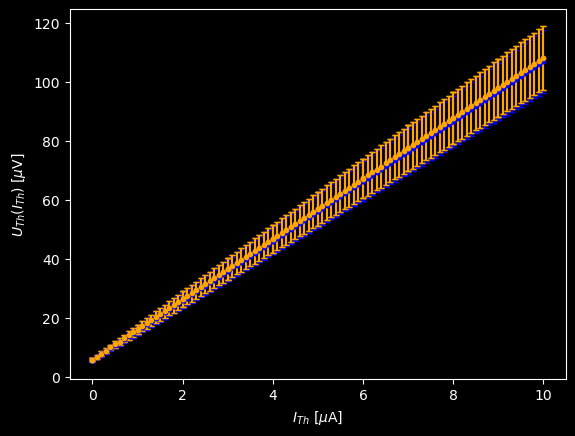

In [44]:
# Heiß:
plt.errorbar(r_hI0_295['I [microA]'],r_hI0_295['U [microV]'],
            #  xerr=uc_r_kI0_295[0],
             fmt='.',
             yerr=uc_r_hi0_295[1],label='295K',capsize=2,color='blue')
plt.errorbar(r_hi0_300['I [microA]'],r_hi0_300['U [microV]'],
            #  xerr=uc_r_ki0_300[0],
             fmt='.',
             yerr=uc_r_hi0_300[1],label='300K',capsize=2,color='orange')
# plt.legend()
# plt.title('Heißes Thermometer')
plt.xlabel('$I_{Th}$ [$\mu$A]')
plt.ylabel('$U_{Th}(I_{Th})$ [$\mu$V]')
# plt.savefig('warmes_therm.png',dpi=600,transparent=True)
plt.show()

### Final Plot

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1251197353.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$I$ [$\mu$A]')
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1251197353.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$U(I)$ [$\mu$V]')


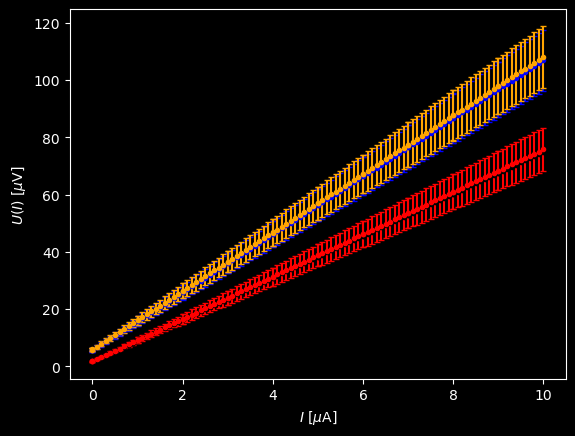

In [47]:

# Heiß:
plt.errorbar(r_hI0_295['I [microA]'],r_hI0_295['U [microV]'],
            #  xerr=uc_r_kI0_295[0],
             fmt='.',
             yerr=uc_r_hi0_295[1],label='295K',capsize=2,color='blue')
plt.errorbar(r_hi0_300['I [microA]'],r_hi0_300['U [microV]'],
            #  xerr=uc_r_ki0_300[0],
             fmt='.',
             yerr=uc_r_hi0_300[1],label='300K',capsize=2,color='orange')
# Kalt:
# data
plt.errorbar(r_kI0_295['I [microA]'],r_kI0_295['U [microV]'],fmt='.',
            #  xerr=uc_r_kI0_295[0],
             yerr=uc_r_kI0_295[1],label='295K',capsize=2,color='k',
             zorder=1)
plt.errorbar(r_ki0_300['I [microA]'],r_ki0_300['U [microV]'],fmt='.',
            #  xerr=uc_r_ki0_300[0],
             yerr=uc_r_ki0_300[1],label='300K',capsize=2,color='r',
             zorder=1)
# plt.legend()
# plt.title('Heißes Thermometer')
plt.xlabel('$I$ [$\mu$A]')
plt.ylabel('$U(I)$ [$\mu$V]')
# plt.savefig('U-I.png',dpi=600,transparent=True)
plt.show()

## Teilaufgabe 2

### Plot

Widerstand des heißen $R_{heiß}(T)$ und kalten Thermometers $R_{kalt}(T)$ in Abhängigkeit
von der Temperatur bei $I_H = 0$

In [48]:
# print(d_lst[1])
print(d_lst[2])
# print(d_lst[25])
print(d_lst[26])

2023-11-09_16-29-08 0001 295K_R_I0(15,10,14,11)T1=294.96K T2=295.28K .txt
2023-11-09_17-31-00 0001 300K_R_I0mA(15,10,14,11)T1=299.92K T2=300.23K .txt


In [49]:
# heiß
df_Rh = pd.DataFrame({
    'R [O]':[10.1173, a300h],
    'T [K]':[295.28,300.23]
})
u_yh = [0.0007,0.0005]
# kalt
df_Rk = pd.DataFrame({
    'R [O]':[7.3148 , 7.3985],
    'T [K]':[295.28,300.23]
})
u_yk = [0.0004,0.0004]


In [50]:
plt.errorbar(df_Rh['T [K]'],df_Rh['R [O]'],yerr=u_yh,fmt='o')# heiß
plt.errorbar(df_Rk['T [K]'],df_Rk['R [O]'],yerr=u_yk,fmt='o')# kalt
plt.xticks([295,300])
plt.yticks([7.3,8.8,10.2])
plt.ylabel('R(T) [$\Omega$]')
plt.xlabel('T [K]')

<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\4089723316.py:5: SyntaxWarning: invalid escape sequence '\O'
  plt.ylabel('R(T) [$\Omega$]')


Text(0.5, 0, 'T [K]')

### Regression Versuch 1

In [51]:
XT2h = sm.add_constant(df_Rh['T [K]']) # heiß
XT2k = sm.add_constant(df_Rk['T [K]']) # kalt
mt2h = sm.WLS(df_Rh['R [O]'],XT2h,weights=df_Rh['R [O]']*0.1)#
mt2k = sm.WLS(df_Rk['R [O]'],XT2k,weights=df_Rk['R [O]']*0.1) #
rt2h = mt2h.fit()
rt2k = mt2k.fit()

In [52]:
print(rt2h.summary())

                            WLS Regression Results                            
Dep. Variable:                  R [O]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                nan
Time:                        10:48:56   Log-Likelihood:                 56.668
No. Observations:                   2   AIC:                            -109.3
Df Residuals:                       0   BIC:                            -111.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8511        inf          0        n

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [53]:
print(rt2k.summary())

                            WLS Regression Results                            
Dep. Variable:                  R [O]   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                nan
Time:                        10:48:58   Log-Likelihood:                 63.867
No. Observations:                   2   AIC:                            -123.7
Df Residuals:                       0   BIC:                            -126.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3219        inf          0        n

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


### Regression Versuch 2

#### ohne Fehler (heiß)

In [54]:
a = sbk.sxy(df_Rh['T [K]'],df_Rh['R [O]'])/sbk.sxsq(df_Rh['T [K]'])
a

0.021221147183523578

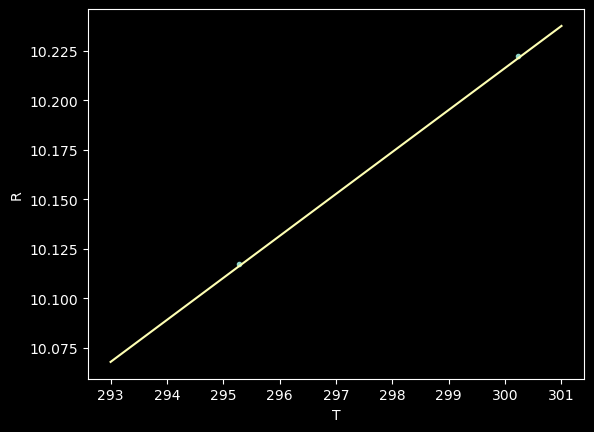

In [60]:
x = np.linspace(293,301)
plt.plot(df_Rh['T [K]'],df_Rh['R [O]'],'.')
plt.xlabel('T')
plt.ylabel('R')
plt.plot(x,x*a+3.85)
plt.show()

#### mit Fehler (heiß)

In [61]:
df_Rh

,R [O],T [K]
0,10.117300,295.28
1,10.222345,300.23


In [62]:
# Welche Sets brauche ich? df_Rh['T [K]'],df_Rh['R [O]'], u_yh, Abschätzung uT = 0.02K
u_t = [0.02,0.02]#np.array()
Rh = np.array([ufloat(10.117300,u_yh[0]),ufloat(10.222345,u_yh[1])])
Th = np.array([ufloat(295.28,0.02),ufloat(300.23,0.02)])

In [63]:
mean_rh = np.mean(Rh)
mean_th = np.mean(Th)
a_err = sbk.sxy(Th,Rh)/sbk.sxsq(Th)
print(a_err)
a_err = ufloat(0.02122,0.00021)
dRh_dT_err = a_err

0.02122+/-0.00021


##### mit lin_reg function

In [64]:
a,b,sig, std=sbk.lin_reg(Th,Rh)
print(a,b)

3.85+/-0.06 0.02122+/-0.00021


#### Mit fehlern (kalt)

In [65]:
df_Rk

,R [O],T [K]
0,7.3148,295.28
1,7.3985,300.23


In [66]:
Rk = np.array([ufloat(7.3148,u_yk[0]),ufloat(7.3985,u_yk[1])])
Tk = np.array([ufloat(295.28,0.02),ufloat(300.23,0.02)])
a_err = sbk.sxy(Tk,Rk)/sbk.sxsq(Tk)
print(a_err)
a_err = ufloat(0.01691,0.00015)
dRk_dT_err = a_err

0.01691+/-0.00015


### final plot

In [67]:
print(dRk_dT_err)
print(dRh_dT_err)

0.01691+/-0.00015
0.02122+/-0.00021


In [68]:
bh = 3.8511
ah = 0.02122
bk = 2.3219
ak = 0.01691
x_temp = np.linspace(293,302)

<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\3723129464.py:11: SyntaxWarning: invalid escape sequence '\O'
  plt.ylabel('R(T) [$\Omega$]')


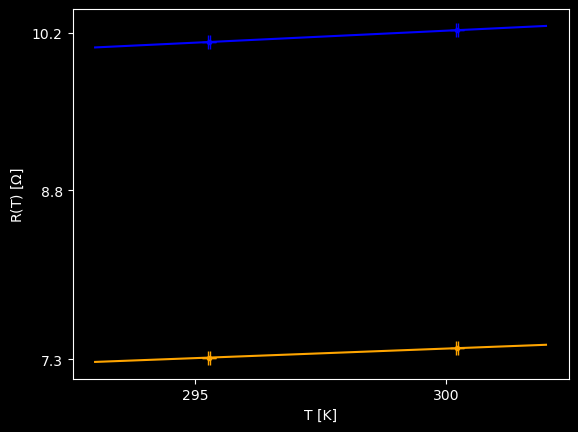

In [71]:
plt.errorbar(df_Rh['T [K]'],df_Rh['R [O]'],
             yerr=u_yh,capsize=5,xerr=0.02,
             fmt='.',color='blue')# heiß
plt.errorbar(df_Rk['T [K]'],df_Rk['R [O]'],
             yerr=u_yk,capsize=5,xerr=0.02,
             fmt='.',color='orange')# kalt
plt.plot(x_temp,ah*x_temp+bh,color='blue')
plt.plot(x_temp,ak*x_temp+bk,color='orange')
plt.xticks([295,300])
plt.yticks([7.3,8.8,10.2])
plt.ylabel('R(T) [$\Omega$]')
plt.xlabel('T [K]')
# plt.savefig('dT-heiß-kalt.png',dpi=600,transparent=True)
plt.show()

## Teilaufgabe 3

Thermospannung US;Au,Pt(IH) in Abhängigkeit des Heizstromes für alle vier
Temperaturen

In [72]:
us_lst = sorted(sbk.find_files_with_us('Data/'))

In [73]:
us_lst

['Data/2023-11-09_16-33-52 0001 295K_Us_I0T1=295.03K T2=295.36K.txt',
 'Data/2023-11-09_16-39-15 0001 295K_Us_I3mAT1=295.04K T2=295.38K.txt',
 'Data/2023-11-09_16-42-36 0001 295K_Us_I6mAT1=295.01K T2=295.36K.txt',
 'Data/2023-11-09_16-44-53 0001 295K_Us_I9mAT1=295.00K T2=295.35K.txt',
 'Data/2023-11-09_16-47-00 0001 295K_Us_I12mAT1=295.00K T2=295.35K.txt',
 'Data/2023-11-09_16-50-48 0001 295K_Us_I15mAT1=295.01K T2=295.36K .txt',
 'Data/2023-11-09_17-31-25 0001 300K_Us_I0mAT1=299.93K T2=300.24K .txt',
 'Data/2023-11-09_17-33-13 0001 300K_Us_I3mAT1=299.98K T2=300.28K .txt',
 'Data/2023-11-09_17-34-52 0001 300K_Us_I6mAT1=300.01K T2=300.32K .txt',
 'Data/2023-11-09_17-37-04 0001 300K_Us_I9mAT1=300.05K T2=300.36K .txt',
 'Data/2023-11-09_17-39-03 0001 300K_Us_I12mAT1=300.06K T2=300.38K .txt',
 'Data/2023-11-09_17-40-59 0001 300K_Us_I15mAT1=300.05K T2=300.38K .txt',
 'Data/2023-11-09_17-44-56 0002 300K_Us_I0mAT1=300.00K T2=300.34K .txt']

In [74]:
# df_us

In [75]:
lst = list(df_us.columns)
lst = lst[:10]

Varianz:
$$ var = \frac{\sum (x_i - \mu)^2}{n-1} $$

In [76]:
df_sub = np.array(df_us.loc[:,lst])
df_mean = []
df_std = []
for i in range(len(df_sub)):
  x = df_sub[i].mean()
  df_mean.append(x)
  varsd = sbk.var(df_sub[i],x)
  y = round(np.sqrt(varsd),3)
  df_std.append(y)

In [77]:
print(df_std)

[np.float64(0.012), np.float64(0.011), np.float64(0.01), np.float64(0.016), np.float64(0.018), np.float64(0.009), np.float64(0.009), np.float64(0.026), np.float64(0.036), np.float64(0.022), np.float64(0.032), np.float64(0.009), np.float64(0.009)]


In [78]:
df_std[7] = 0.030
df_std[8] = 0.040
df_std[9] = 0.02
df_std[10] = 0.03

print(df_std)

[np.float64(0.012), np.float64(0.011), np.float64(0.01), np.float64(0.016), np.float64(0.018), np.float64(0.009), np.float64(0.009), 0.03, 0.04, 0.02, 0.03, np.float64(0.009), np.float64(0.009)]


In [79]:
for i in range(len(df_mean)):
  df_mean[i] = round(df_mean[i],3)

In [80]:
df_us['U [10^-6V]'] = df_mean
df_us['Std U [10^-6V]'] = df_std

In [81]:
df_us.head()

,Vs1 [10^-6],Vs2 [10^-6],Vs3 [10^-6],Vs4 [10^-6],Vs5 [10^-6],Vs6 [10^-6],Vs7 [10^-6],Vs8 [10^-6],Vs9 [10^-6],Vs10 [10^-6],Time,T1 [K],Sample T [K],I [mA],File Number,Wanted T [K],U [10^-6V],Std U [10^-6V]
0,5.533440,5.517621,5.531168,5.515758,5.507485,5.514308,5.511925,5.512130,5.520507,5.491035,16:33:52,295.03,295.36,0,1,295,5.516,0.012
1,5.523303,5.532097,5.508001,5.504897,5.500244,5.513480,5.503651,5.504582,5.525678,5.519991,16:39:15,295.04,295.38,3,1,295,5.514,0.011
2,5.436539,5.416997,5.399003,5.414929,5.421133,5.425684,5.423714,5.417716,5.428574,5.422059,16:42:36,295.01,295.36,6,1,295,5.421,0.010
3,5.196105,5.183078,5.197967,5.192589,5.178214,5.182555,5.186998,5.218333,5.206027,5.227640,16:44:53,295.00,295.35,9,1,295,5.197,0.016
4,5.007058,5.006028,4.977899,4.982552,4.975934,4.972624,4.970242,4.962072,4.962176,4.953801,16:47:00,295.00,295.35,12,1,295,4.977,0.018


In [82]:
I = np.array([0,3,6,9,12,15])

In [83]:
df_us295 = df_us.loc[:5,['I [mA]','Sample T [K]','U [10^-6V]','Std U [10^-6V]']]
df_us300 = df_us.loc[6:11,['I [mA]','Sample T [K]','U [10^-6V]','Std U [10^-6V]']]


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2761822393.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$U_S(I)$ [$\mu$V]')


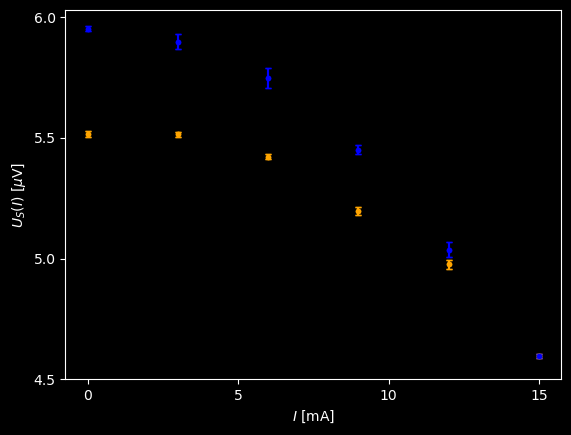

In [85]:
plt.errorbar(df_us295['I [mA]'],df_us295['U [10^-6V]'],yerr=df_us295['Std U [10^-6V]'],fmt='.',capsize=2,color='orange')
plt.errorbar(df_us300['I [mA]'],df_us300['U [10^-6V]'],yerr=df_us300['Std U [10^-6V]'],fmt='.',capsize=2,color='b')
plt.xticks([0,5,10,15])
plt.yticks([4.5,5,5.5,6])
plt.xlabel('$I$ [mA]')
plt.ylabel('$U_S(I)$ [$\mu$V]')
# plt.savefig('A1T3-b.png',dpi=600,transparent=True)
plt.show()

## Teilaufgabe 4

### Vorbereitung

In [87]:
d_path = 'Data/'
txt_files = sorted([file for file in os.listdir(d_path) if file.endswith('.txt')])
# txt_files

In [90]:
# list for delta T
h_lst_295 = []
k_lst_295 = []
h_lst_300 = []
k_lst_300 = []

h = '1,8,16,9'
k = '15,10,14,11'
T295 = '295K'
T300 = '300K'

for i in range(len(txt_files)):
  if T295 in txt_files[i]:
    if 'I0' in txt_files[i]:
      pass
    else:
      if 'Zusammenfassung' in txt_files[i]:
        pass
      else:
        if h in txt_files[i]:
          h_lst_295.append(sbk.lst_of_rs(d_path + txt_files[i],T295,h)[0])
        elif k in txt_files[i]:
          k_lst_295.append(sbk.lst_of_rs(d_path + txt_files[i],T295,k)[0])
  elif T300 in txt_files[i]:
    if 'I0' in txt_files[i]:
      pass
    else:
      if 'Zusammenfassung' in txt_files[i]:
        pass
      else:
        if h in txt_files[i]:
          h_lst_300.append(sbk.lst_of_rs(d_path + txt_files[i],T300,h)[0])
        elif k in txt_files[i]:
          k_lst_300.append(sbk.lst_of_rs(d_path + txt_files[i],T300,k)[0])

In [91]:
print(len(h_lst_295))
print(len(k_lst_295))
print(len(k_lst_300))
print(len(h_lst_300))

5
5
5
5


In [92]:
h_lst_295[0][0].head()

,I [microA],U [microV],P [W],Resistance,SD [s],VL [V]
1,0.0,5.753444,0.000000e+00,0.00000,5.00,1.0
2,0.0,5.740521,0.000000e+00,0.00000,1.00,1.0
3,0.1,6.768974,6.768974e-13,67.68974,0.01,1.0
4,0.2,7.785017,1.557003e-12,38.92508,0.01,1.0
5,0.3,8.792269,2.637681e-12,29.30756,0.01,1.0


In [93]:
r_h_300 = []
r_k_300 = []
r_h_295 = []
r_k_295 = []

for i in range(5):
  x_300k = sm.add_constant(k_lst_300[i][0]['I [microA]'])
  x_295k = sm.add_constant(k_lst_295[i][0]['I [microA]'])
  x_300h = sm.add_constant(h_lst_300[i][0]['I [microA]'])
  x_295h = sm.add_constant(h_lst_295[i][0]['I [microA]'])

  m_300k = sm.OLS(k_lst_300[i][0]['U [microV]'],x_300k).fit()
  m_295k = sm.OLS(k_lst_295[i][0]['U [microV]'],x_295k).fit()
  m_300h = sm.OLS(h_lst_300[i][0]['U [microV]'],x_300h).fit()
  m_295h = sm.OLS(h_lst_295[i][0]['U [microV]'],x_295h).fit()

  a300k_err = ufloat(m_300k.params[1],m_300k.bse[1])
  r_k_300.append(a300k_err)

  a300h_err = ufloat(m_300h.params[1],m_300h.bse[1])
  r_h_300.append(a300h_err)

  a295k_err = ufloat(m_295k.params[1],m_295k.bse[1])
  r_k_295.append(a295k_err)

  a295h_err = ufloat(m_295h.params[1],m_295h.bse[1])
  r_h_295.append(a295h_err)

C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1581664312.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a300k_err = ufloat(m_300k.params[1],m_300k.bse[1])
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1581664312.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a300h_err = ufloat(m_300h.params[1],m_300h.bse[1])
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\1581664312.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

In [94]:
print(r_h_295[1])

10.1375+/-0.0005


### Thermospannung
Thermospannung US;Au,Pt($\delta T$) in Abhängigkeit des Temperaturgradienten für
alle vier Temperaturen

$$ \delta T = \Delta T_{heiß} - \Delta T_{kalt}\\ \Delta T_i = \frac{R(P)-R(P=0)}{dR(P=0)/dT_i},\; \forall i \in \left\lbrace heiß,kalt\right\rbrace $$

- die $R(P)$ sind bspw. in r_h_295
- $dR(P=0)/dT_{heiß}$

In [95]:
print(dRk_dT_err)
print(dRh_dT_err)

0.01691+/-0.00015
0.02122+/-0.00021


In [96]:
print(a_295_err1)
print(a_300_err1)

7.31476+/-0.00035
7.3985+/-0.0004


#### $\delta T_{295}$

In [97]:
r_h_295

[10.123769682988229+/-0.0005156499209786695,
 10.137488929420888+/-0.0004998099859425305,
 10.16375710396413+/-0.00047012341848341873,
 10.203988748340903+/-0.0004458111759213752,
 10.254224930358399+/-0.0005183882873186266]

In [98]:
r_k_295

[7.323551598678629+/-0.0003058740294660931,
 7.322688714649543+/-0.00024588472741489013,
 7.322514787362053+/-0.0002606304610375017,
 7.326101749643824+/-0.0003109997066363446,
 7.333262255807776+/-0.0002910702687262452]

In [99]:
Delta_k295 = []
Delta_h295 = []
for i in range(5):
  x = (r_k_295[i]-a_295_err1)/dRk_dT_err
  print(r_k_295[i]-a_295_err1)
  x1 = (r_h_295[i]-a_295_err1)/dRh_dT_err
  print(r_h_295[i]-a_295_err1,'\n')
  Delta_k295.append(x)
  Delta_h295.append(x1)
print(Delta_k295)
Delta_h295

0.0088+/-0.0005
2.8090+/-0.0006 

0.0079+/-0.0004
2.8227+/-0.0006 

0.0077+/-0.0004
2.8490+/-0.0006 

0.0113+/-0.0005
2.8892+/-0.0006 

0.0185+/-0.0005
2.9395+/-0.0006 

[0.5196122797052017+/-0.028041435738943642, 0.46858424723416764+/-0.025818605447188562, 0.4582987778379199+/-0.026305325538226728, 0.6704195514494529+/-0.028486857536315743, 1.0938675800687527+/-0.02878061737268555]


[132.3753406201421+/-1.3103607568616429,
 133.0218649572137+/-1.3167437965701356,
 134.25976196679156+/-1.3289674529695028,
 136.15569242752542+/-1.347707820480724,
 138.52309026058367+/-1.371188466319668]

In [100]:
delta_295 = []
for i in range(5):
  x = Delta_h295[i]-Delta_k295[i]
  delta_295.append(x)

In [101]:
delta_295

[131.8557283404369+/-1.3103944967488337,
 132.55328070997953+/-1.3167319119932814,
 133.80146318895365+/-1.3289652226722224,
 135.48527287607598+/-1.3477499665388635,
 137.42922268051493+/-1.3712360248960596]

#### $\delta T_{300}$

In [102]:
Delta_k300 = []
Delta_h300 = []
delta_300 = []
for i in range(5):
  x = (r_k_300[i]-a_300_err1)/dRk_dT_err
  # print(r_k_300[i]-a_300_err1)
  x1 = (r_h_300[i]-a_300_err1)/dRh_dT_err
  # print(r_h_300[i]-a_300_err1,'\n')
  x2 = x1-x
  Delta_k300.append(x)
  Delta_h300.append(x1)
  delta_300.append(x2)
print(Delta_k300)
Delta_h300

[0.027387477788805344+/-0.0261634444482216, 0.0475141261210408+/-0.02706233204379394, 0.26371574743706466+/-0.027447614080878507, 0.4806247923342918+/-0.02565097785398785, 0.7867716558121653+/-0.02977886019231711]


[133.3339085444325+/-1.3198231409435197,
 134.22699214539745+/-1.3286810086421226,
 135.49739904211538+/-1.3412060976556137,
 137.4173988467818+/-1.3602426433603747,
 139.71940577648544+/-1.3830530721587428]

In [103]:
print(delta_300[0].n)
print(delta_300[0].s)

133.30652106664368
1.3198083118390673


### Regression:

In [104]:
x = np.linspace(130,140,1000)
y = np.linspace(5,6,1000)

In [105]:
y_us295 = df_us.loc[1:5,['U [10^-6V]']]
u_y_us295 = df_us.loc[1:5,['Std U [10^-6V]']]
y_us300 = df_us.loc[7:11,['U [10^-6V]']]
u_y_us300 = df_us.loc[7:11,['Std U [10^-6V]']]
print(len(y_us295))
print(len(y_us300))

5
5


In [106]:
u_y_us300#['Std U [10^-6V]']

,Std U [10^-6V]
7,0.030
8,0.040
9,0.020
10,0.030
11,0.009


In [107]:
u295 = []
u300 = []
x295 = []
x300 = []
for i in range(5):
  u300.append(round(delta_300[i].s,1))
  x300.append(round(delta_300[i].n,1))
  u295.append(round(delta_295[i].s,1))
  x295.append(round(delta_295[i].n,1))

In [108]:
x295

[131.9, 132.6, 133.8, 135.5, 137.4]

In [109]:
X295 = sm.add_constant(x295)
X300 = sm.add_constant(x300)
m295 = sm.WLS(y_us295['U [10^-6V]'],X295,weights=u_y_us295)
m300 = sm.WLS(y_us300['U [10^-6V]'],X300,weights=u_y_us300)
r295 = m295.fit()
r300 = m300.fit()

In [110]:
print(r295.summary())
print(r300.summary())

                            WLS Regression Results                            
Dep. Variable:             U [10^-6V]   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     378.7
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           0.000296
Time:                        10:52:47   Log-Likelihood:                 11.057
No. Observations:                   5   AIC:                            -18.11
Df Residuals:                       3   BIC:                            -18.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8800      1.117     24.058      0.0

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### Final PLot

In [111]:
a295 = r295.params[1]
b295 = r295.params[0]
u_a_295 = r295.bse[1]
u_b_295 = r295.bse[0]
a300 = r300.params[1]
b300 = r300.params[0]
u_a_300 = r300.bse[1]
u_b_300 = r300.bse[0]

C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2673164475.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a295 = r295.params[1]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2673164475.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b295 = r295.params[0]
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\2673164475.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_a_295 = r295.bse[1]
C:\Users\benjf\AppData\Local\Temp\

In [112]:
print(ufloat(a295,u_a_295))
print(ufloat(a300,u_a_300))

-0.162+/-0.008
-0.242+/-0.010


In [113]:
print(a295)

-0.16191013289372394


In [114]:
u_y_us295

,Std U [10^-6V]
1,0.011
2,0.010
3,0.016
4,0.018
5,0.009


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\787336962.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$\delta T\; [K]$')
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\787336962.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$U_S(\delta T)\; [\mu V]$')


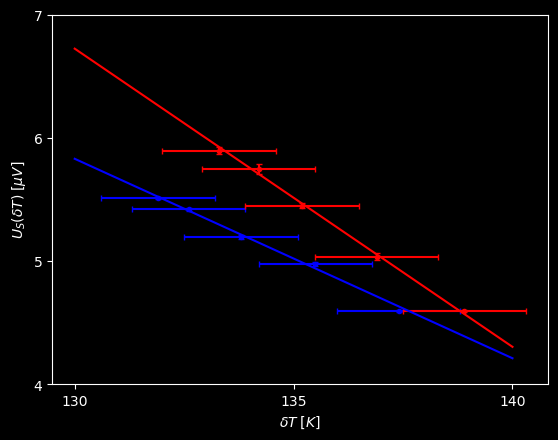

In [117]:
plt.plot(x,a295*x+b295,color='blue',zorder=2)
plt.plot(x,a300*x+b300,color='red',zorder=2)
plt.errorbar(x295,y_us295['U [10^-6V]'],
             xerr=u295,yerr=u_y_us295['Std U [10^-6V]'],
             fmt='.',capsize=2,
             color='blue',zorder=1)
plt.errorbar(x300,y_us300['U [10^-6V]'],
             xerr=u300,yerr=u_y_us300['Std U [10^-6V]'],
             fmt='.',capsize=2,
             color='red',zorder=1)
plt.xticks([130,135,140])
plt.yticks([4,5,6,7])
plt.xlabel('$\delta T\; [K]$')
plt.ylabel('$U_S(\delta T)\; [\mu V]$')
# plt.savefig('Thermospannung-delta-T.png',dpi=600,transparent=True)
plt.show()

### test

In [118]:
# y_us295 = df_us.loc[1:5,['U [10^-6V]']]*1e-6
# u_y_us295 = df_us.loc[1:5,['Std U [10^-6V]']]*1e-6
# y_us300 = df_us.loc[7:11,['U [10^-6V]']]*1e-6
# u_y_us300 = df_us.loc[7:11,['Std U [10^-6V]']]*1e-6
# print(len(y_us295))
# print(len(y_us300))

In [119]:
# y_us295

In [120]:
# u295 = []
# u300 = []
# # x295 = []
# x300 = []
# for i in range(5):
#   u300.append(round(delta_300[i].s,1))
#   x300.append(round(delta_300[i].n,1))
#   u295.append(round(delta_295[i].s,1))
#   x295.append(round(delta_295[i].n,1))

In [121]:
# X295 = sm.add_constant(x295)
# X300 = sm.add_constant(x300)
# m295 = sm.WLS(y_us295['U [10^-6V]'],X295,weights=u_y_us295)
# m300 = sm.WLS(y_us300['U [10^-6V]'],X300,weights=u_y_us300)
# r295 = m295.fit()
# r300 = m300.fit()

In [122]:
# # print(r295.summary())
# print(r300.summary())

## Teilaufgabe 5

Relativer Seebeck-Koeffizient SAu,Pt(T) in Abhängigkeit von der Temperatur

In [123]:
S_rel = np.array([a295,a300])*(-1)
u_s = [u_a_295,u_a_300]
T = np.array([295,300])
print(u_s)

[np.float64(0.008320444997184127), np.float64(0.009831031703914497)]


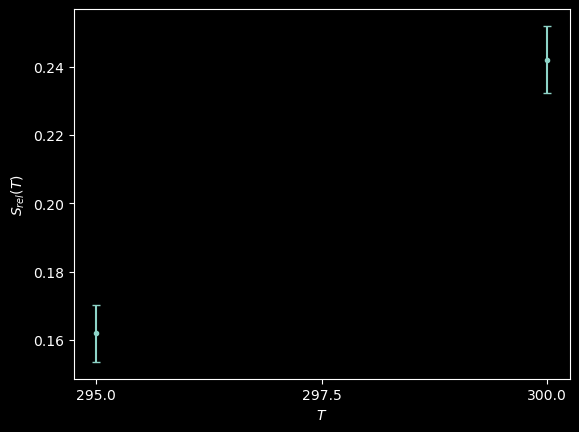

In [126]:
plt.errorbar(T,S_rel,
             yerr=u_s,
             fmt='.',
             capsize=3)
# plt.yticks([-.15,-.2,-.25])
plt.xticks([295,297.5,300])
plt.xlabel('$T$')
plt.ylabel('$S_{rel}(T)$')
plt.show()

### Regression

In [127]:
t = S_rel*1e-6

In [128]:
XS = sm.add_constant(T)
ms = sm.WLS(t,XS,weights=u_s)
rs = ms.fit()
print(rs.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                nan
Time:                        10:53:56   Log-Likelihood:                 91.208
No. Observations:                   2   AIC:                            -178.4
Df Residuals:                       0   BIC:                            -181.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.566e-06        inf         -0        n

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [129]:
XS = sm.add_constant(T)
ms = sm.WLS(S_rel,XS,weights=u_s)
rs = ms.fit()
print(rs.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                nan
Time:                        10:53:57   Log-Likelihood:                 63.505
No. Observations:                   2   AIC:                            -123.0
Df Residuals:                       0   BIC:                            -125.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5658        inf         -0        n

c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\benjf\anaconda3\envs\projects\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [130]:
S1 = np.array([ufloat(S_rel[0],u_s[0]),ufloat(S_rel[1],u_s[1])])

In [131]:
sa_err = sbk.sxy(T,S1)/sbk.sxsq(T)
u_sa = round(sa_err.s,4)
sa = round(sa_err.n,4)
sa_err = ufloat(sa,u_sa)
sa_err

0.016+/-0.0026

### final plot

In [132]:
rs.params[0]

np.float64(-4.565824403167655)

In [133]:
xt = np.linspace(294.9,300.1,1000)
yt = sa * xt + rs.params[0]
print(rs.params[0])
print(sa)

-4.565824403167655
0.016


In [134]:
T = np.array([295,300])
S_rel = np.array([S1[0].n,S1[1].n])
u_s = np.array([S1[0].s,S1[1].s])
print(S_rel)

[0.16191013 0.24204123]


In [135]:
print(S1)

[0.16191013289372394+/-0.008320444997184127
 0.24204122672527284+/-0.009831031703914497]


<>:9: SyntaxWarning: invalid escape sequence '\;'
<>:9: SyntaxWarning: invalid escape sequence '\;'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\386634302.py:9: SyntaxWarning: invalid escape sequence '\;'
  plt.ylabel('$S_{rel}(T)\; [\mu V/K]$')


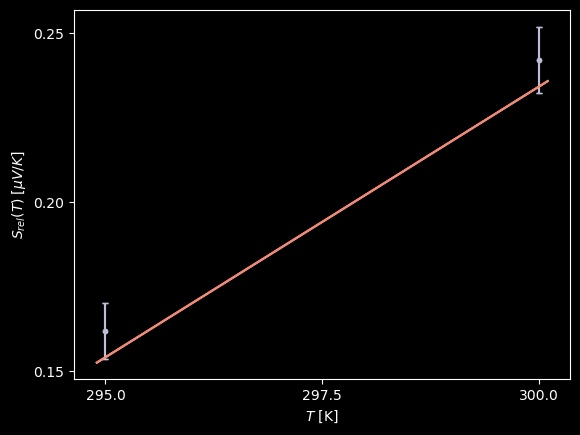

In [137]:
plt.errorbar(T,S_rel,
             yerr=u_s,
             fmt='.', capsize=2,
             zorder=1)
plt.plot(xt,yt)
plt.yticks([.15,.2,.25])
plt.xticks([295,297.5,300])
plt.xlabel('$T$ [K]')
plt.ylabel('$S_{rel}(T)\; [\mu V/K]$')
# plt.savefig('rel_Seebeck_Koeff1.png',dpi=600,transparent=True)
plt.show()

# Aufgabe 2

In [138]:
u_s

array([0.00832044, 0.00983103])

In [139]:
u_s[0] = round(u_s[0],3)
u_s[1] = round(u_s[1],3)

In [140]:
S_al = ufloat(0.0037,0.0004)  #*1e-6
S_r_err = np.array([ufloat(round(S_rel[0],3),round(u_s[0],3)),ufloat(round(S_rel[1],3),round(u_s[1]),3)])

$$ S_{rel} = S_{Al} - S_{pt} $$

In [141]:
S_r_err

array([0.162+/-0.008, < 3 = 0.242+/-0 >], dtype=object)

In [142]:
Spt = S_al - S_r_err

In [143]:
Spt

array([-0.1583+/-0.008009993757800314, -0.23829999999999998+/-0.0004],
      dtype=object)

In [144]:
u_sp = [round(Spt[0].s,3),round(Spt[1].s,3)]
S_pt = [round(Spt[0].n,3),round(Spt[1].n,3)]
S_pt_err = np.array([ufloat(S_pt[0],u_sp[0]),ufloat(S_pt[1],u_sp[1])])

In [145]:
S_pt_err

array([-0.158+/-0.008, -0.238+/-0], dtype=object)

In [146]:
T = [295,300]

In [147]:
plt.errorbar(T,S_pt,
              fmt='.',
              yerr=u_sp,
             capsize=3)
plt.xlabel('T [K]')
plt.ylabel('$S_{pt}(T)\; [\mu V/K]$')
plt.xticks([295,300])
plt.yticks([-.15,-.2,-.24])
plt.savefig('Abs_SBK_pt2.png',dpi=600,transparent=True)

<>:6: SyntaxWarning: invalid escape sequence '\;'
<>:6: SyntaxWarning: invalid escape sequence '\;'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\563477477.py:6: SyntaxWarning: invalid escape sequence '\;'
  plt.ylabel('$S_{pt}(T)\; [\mu V/K]$')


# Aufgabe 3

gesucht: $\alpha (T)$
$$ \alpha = \frac{1}{R(T,P=0)} \partial_{T} R(T,P=0)$$

In [148]:
R0_295h = ufloat(10.1173,0.0007)
R0_300h = ufloat(10.2223,0.0005)
R0_295k= ufloat(7.3148,0.0004)
R0_300k= ufloat(7.3985,0.0004)
T = [295,300]
dRh = ufloat(0.02122,0.00021)
dRk = ufloat(0.01691,0.00015)
diff_295 = R0_295h - R0_295k
diff_300 = R0_300h - R0_300k
diff_dR = dRh-dRk

In [149]:
alpha_h = [1/R0_295h * dRh,1/R0_300h * dRh]
alpha_k = [1/R0_295k * dRk,1/R0_300k * dRk]
alpha_diff = [1/diff_295 * diff_dR,1/diff_300 * diff_dR]


In [150]:
uh = [alpha_h[0].s,alpha_h[1].s]
uk = np.array([alpha_k[0].s,alpha_k[1].s])
ud = np.array([alpha_diff[0].s,alpha_diff[1].s])

yh = np.array([alpha_h[0].n,alpha_h[1].n])
yk = np.array([alpha_k[0].n,alpha_k[1].n])
yd = np.array([alpha_diff[0].n,alpha_diff[1].n])

Vergleichswert:
$$ \alpha = 3,9 \cdot 10^{-3} \frac{1}{C}= 0.014  \cdot 10^{-3} \frac{1}{K}$$

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
C:\Users\benjf\AppData\Local\Temp\ipykernel_8572\4061516790.py:15: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\\alpha$  [$1\cdot 10^{-3}/K$]')


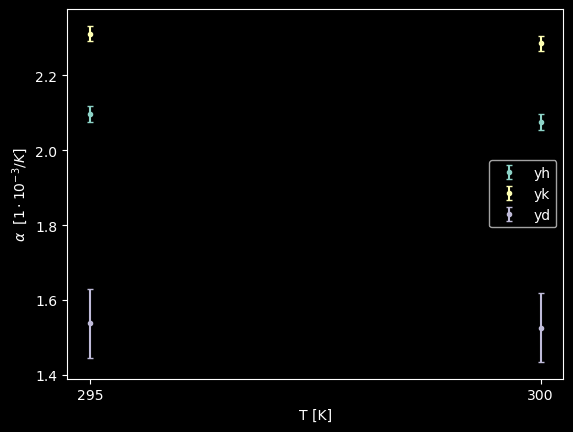

In [156]:
plt.errorbar(T,yh*1e3,
             fmt='.',
             yerr=np.array(uh)*1e3,
             capsize=2,label='yh')
plt.errorbar(T,yk*1e3,fmt='.',
             yerr=uk*1e3,
             capsize=2,label='yk')
plt.errorbar(T,yd*1e3,fmt='.',
             yerr=ud*1e3,
             capsize=2, label='yd')
plt.legend()
plt.xticks([295,300])
# plt.yticks([2.26,2.3,2.34])
plt.xlabel('T [K]')
plt.ylabel('$\\alpha$  [$1\cdot 10^{-3}/K$]')
# plt.savefig('alpha1.png',dpi=600,transparent=True)
plt.show()

In [157]:
print(uk)
print(yk)

[2.05067603e-05 2.02747565e-05]
[0.00231175 0.0022856 ]


In [158]:
yk_err = np.array([ufloat(yk[0],uk[0]),ufloat(yk[1],uk[1])])
yk_err

array([0.002311751517471428+/-2.050676029560565e-05,
       0.0022855984321146178+/-2.027475651635177e-05], dtype=object)

In [159]:
print(np.mean(yk_err*1e3))

2.299+/-0.014
